In [4]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Lambda
from torchvision import datasets
import matplotlib.pyplot as plt

# Cargado de Dataset Fashion MNIST

In [5]:
# Cargar Datasets Fashion MNIST
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [01:29<00:00, 296672.96it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 55655.86it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:15<00:00, 291432.55it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 1283497.41it/s]


Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [6]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [7]:
len(training_data)

50000

In [8]:
len(validation_data)

10000

In [9]:
len(test_data)

10000

#### Visualizando los datos a utilizar

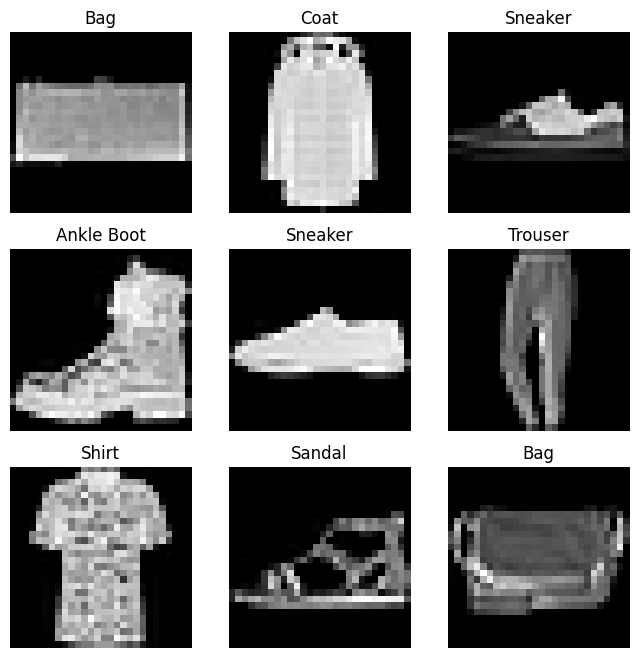

In [10]:

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Data Loader

In [11]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Definiendo la red neuronal

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self,hidden_units,input_size,num_classes):
        super().__init__()

        all_layers = [nn.Flatten()] # Capa flatten para convertir imagen en vector de entrada

        for hidden_unit in hidden_units: # Agrego capas como indique el parametro
            layer = nn.Linear(input_size, hidden_unit)
            all_layers.append(layer)
            all_layers.append(nn.Sigmoid())
            input_size = hidden_unit

        all_layers.append(nn.Linear(hidden_units[-1],num_classes))

        self.model = nn.Sequential(*all_layers)

    def forward(self, x):
        logits = self.model(x)
        return logits

In [13]:
hidden_units = [32]
image_size = training_data[0][0].shape
input_size = image_size[0] * image_size[1] * image_size [2]

modelo = NeuralNetwork(hidden_units,input_size,10)
print(modelo)

NeuralNetwork(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [22]:
def accuracy(model, dataloader):
    model = model.eval()

    correct = 0.0
    total_examples = 0

    for i, (features, labels) in enumerate(dataloader):
        with torch.no_grad():
            logits = model(features)
        
        predictions = torch.argmax(logits, dim = 1)

        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)
    
    return correct / total_examples

In [25]:
def train_loop(train_dataloader, validation_dataloader, model, loss_fn, optimizer):
    size = len(train_dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    plot_loss = []
    for batch, (X, y) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            plot_loss.append(loss)

    train_acc = accuracy(model, train_dataloader)
    val_acc = accuracy(model, validation_dataloader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")
    return train_acc*100, val_acc*100

In [20]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.inference_mode():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Entrenamiento del modelo

Probamos con 10 épocas y 0,01 learning rate

In [28]:
learning_rate = 0.01
batch_size = 64

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(modelo.parameters(), lr=learning_rate)

train_acc = []
val_acc = []


epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    t_acc, v_acc = train_loop(train_dataloader, validation_dataloader, modelo, loss_fn, optimizer)
    train_acc.append(t_acc)
    val_acc.append(v_acc)


Epoch 1
-------------------------------
loss: 0.488114  [   64/50000]
loss: 0.670225  [ 6464/50000]
loss: 0.420328  [12864/50000]
loss: 0.511019  [19264/50000]
loss: 0.592860  [25664/50000]
loss: 0.468399  [32064/50000]
loss: 0.580095  [38464/50000]
loss: 0.464620  [44864/50000]
Train Acc 82.18% | Val Acc 82.26%
Epoch 2
-------------------------------
loss: 0.575338  [   64/50000]
loss: 0.455008  [ 6464/50000]
loss: 0.397732  [12864/50000]
loss: 0.460191  [19264/50000]
loss: 0.560606  [25664/50000]
loss: 0.386328  [32064/50000]
loss: 0.283430  [38464/50000]
loss: 0.617759  [44864/50000]
Train Acc 82.48% | Val Acc 82.49%
Epoch 3
-------------------------------
loss: 0.334374  [   64/50000]
loss: 0.339846  [ 6464/50000]
loss: 0.547434  [12864/50000]
loss: 0.612915  [19264/50000]
loss: 0.706691  [25664/50000]
loss: 0.614641  [32064/50000]
loss: 0.298865  [38464/50000]
loss: 0.528739  [44864/50000]
Train Acc 82.53% | Val Acc 82.80%
Epoch 4
-------------------------------
loss: 0.628282  [ 

# Evaluación del modelo

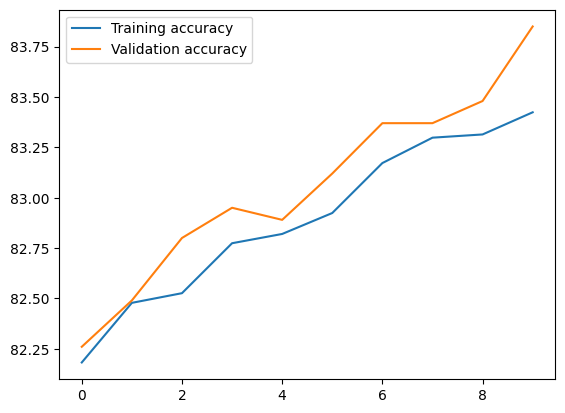

In [29]:
plt.plot(train_acc, label = "Training accuracy")
plt.plot(val_acc, label = "Validation accuracy")

plt.legend()
plt.show()